In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
# directories

main_dir = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
train_folder = os.path.join(main_dir, 'train')
test_folder = os.path.join(main_dir, 'test')

## 1. Download train dataset

In [3]:
train_df = pd.read_csv(os.path.join(main_dir, 'train.csv'))
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


## 2. Investigate train dataset and preprocess it

In [4]:
print(len(train_df))
print('class null values: {:.2f}%'.format(train_df['class'].isna().sum() / len(train_df) * 100))
print('segmentation null values: {:.2f}%'.format(train_df['segmentation'].isna().sum() / len(train_df) * 100))

115488
class null values: 0.00%
segmentation null values: 70.64%


In [5]:
# how many mask-classes are presented
classes = train_df.loc[:, 'class'].unique().tolist()
classes

['large_bowel', 'small_bowel', 'stomach']

In [6]:
# does each image have three masks (by number of classes)?
for cl in classes:
    print('{}: {}'.format(cl, len(train_df[train_df['class'] == cl])))

large_bowel: 38496
small_bowel: 38496
stomach: 38496


In [7]:
# group train dataset by id, add 3 new columns: 'large_bowel', 'small_bowel', 'stomach'
#--------------------------------------------------------------------------------------
train_df_grouped = train_df.copy()
train_df_grouped.set_index('id', inplace = True)

seg_list = []
for cl in classes:
    seg = train_df_grouped[train_df_grouped['class'] == cl]['segmentation']
    seg.name = cl
    seg_list.append(seg)
    
train_df_grouped = pd.concat(seg_list, axis=1).reset_index()
train_df_grouped.fillna('', inplace = True)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,,,
1,case123_day20_slice_0002,,,
2,case123_day20_slice_0003,,,
3,case123_day20_slice_0004,,,
4,case123_day20_slice_0005,,,


In [8]:
def get_case_day_slice(x):
    

    case = re.search('case[0-9]+', x).group()[len('case'):]
    day = re.search('day[0-9]+', x).group()[len('day'):]
    slice_ = re.search('slice_[0-9]+', x).group()[len('slice_'):]
    return case, day, slice_

In [9]:
from glob import glob
import re

case_day_slice = ['case', 'day', 'slice_']

def process_df(df, path):
    
    df = df.copy()
    df.loc[:, case_day_slice] = df.id.apply(get_case_day_slice).to_list()
    
    # get list of all images 
    all_images = glob(os.path.join(path, "**", "*.png"), recursive = True)
    img_df = pd.DataFrame(all_images, columns = ['full_path'])
    img_df.loc[:, case_day_slice] = img_df.full_path.apply(get_case_day_slice).to_list()
    
    return df.merge(img_df, on = case_day_slice, how = 'left')

In [10]:
train_df_grouped = process_df(train_df_grouped, train_folder)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach,case,day,slice_,full_path
0,case123_day20_slice_0001,,,,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...
1,case123_day20_slice_0002,,,,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...
2,case123_day20_slice_0003,,,,123,20,0003,/kaggle/input/uw-madison-gi-tract-image-segmen...
3,case123_day20_slice_0004,,,,123,20,0004,/kaggle/input/uw-madison-gi-tract-image-segmen...
4,case123_day20_slice_0005,,,,123,20,0005,/kaggle/input/uw-madison-gi-tract-image-segmen...


In [11]:
# Remove mislabeled training data

# thank you:
# https://www.kaggle.com/code/caomaobin/uw-madison-data-incorrect-in-case7day0
# https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda

train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 7) | (train_df_grouped['day'] != 0)].reset_index(drop = True)
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 81) | (train_df_grouped['day'] != 30)].reset_index(drop = True)

## 3. Encode/decode RLE mask functions

In [12]:
# see: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

# from competition overview:
# "pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).""

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

## 4. Display several examples

### 4.1 Investigate different ways to open/represent image

This part of notebook appeared when I was wondering what approach to open/decode images would be better to use for exact this project. You can safely skip this part of the notebook 

In [13]:
# get an example of image having non-null 'large_bowel' mask
example_row = train_df_grouped[train_df_grouped['large_bowel'] != ''].iloc[0, :]
example_row

id                                      case123_day20_slice_0075
large_bowel    23058 4 23323 6 23588 8 23854 9 24119 10 24385...
small_bowel                                                     
stomach        12388 11 12652 14 12916 18 13180 22 13445 24 1...
case                                                         123
day                                                           20
slice_                                                      0075
full_path      /kaggle/input/uw-madison-gi-tract-image-segmen...
Name: 74, dtype: object

In [14]:
img_path = example_row.full_path
img_path

'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0075_266_266_1.50_1.50.png'

In [15]:
# display an image
# + image size
# + values of 100th row
import matplotlib.pyplot as plt

def print_img_info(img):
    img_arr = np.asarray(img)
    print(img_arr.shape)
    print(img_arr[100])
    plt.imshow(img)

(266, 266)
[0.         0.         0.         0.         0.         0.
 0.00666819 0.00637827 0.00579843 0.00724804 0.00782788 0.00492866
 0.00492866 0.00608835 0.00521859 0.02348363 0.05740444 0.07016098
 0.07364004 0.04696727 0.02319371 0.01565576 0.01188678 0.0162356
 0.02580301 0.03479057 0.05073625 0.05624475 0.04841688 0.03044175
 0.01275654 0.03102159 0.03739986 0.03392081 0.02899214 0.03421073
 0.03826963 0.03102159 0.03768978 0.04000916 0.03421073 0.03392081
 0.03392081 0.0365301  0.04029908 0.03768978 0.03682002 0.03566033
 0.03595025 0.03624018 0.03566033 0.03508049 0.03566033 0.03421073
 0.03044175 0.03073167 0.03479057 0.04261845 0.04116884 0.03566033
 0.03450065 0.03913939 0.04493782 0.040589   0.03537041 0.03595025
 0.03797971 0.04000916 0.04000916 0.04116884 0.03797971 0.04000916
 0.03739986 0.03942931 0.04377813 0.03826963 0.03508049 0.03855955
 0.04290837 0.03971924 0.04348821 0.04319829 0.03913939 0.03884947
 0.03739986 0.03305104 0.03739986 0.04522774 0.040589   0.03

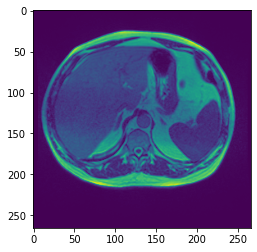

In [16]:
# matplotlib

# from documentation:
# PNG images are returned as float arrays (0-1). 
# All other formats are returned as int arrays, with a bit depth determined by the file's contents.

# all values divided by 255 * 255

import matplotlib.image as mpimg
print_img_info(mpimg.imread(img_path, format = 'png'))

(266, 266)
[ 0  0  0  0  0  0  1  1  1  1  2  1  1  1  1  6 14 17 18 12  5  4  3  4
  6  8 12 14 12  7  3  7  9  8  7  8  9  7  9 10  8  8  8  9 10  9  9  9
  9  9  9  8  9  8  7  7  8 10 10  9  8 10 11 10  9  9  9 10 10 10  9 10
  9 10 11  9  8  9 10 10 11 11 10  9  9  8  9 11 10  9 10 10 10  9  9 10
  9 10 10 10 10  9  9 10 10  8  9  9  9 10  9 10  9  9  8  7  7 10 10 10
 10  9 10 10 10  9  8 10 10 10 12 14 16 16 18 20 21 21 18 15 14 14 16 20
 21 24 22 20 19 13  7  6  7  8 12 17 22 20 12  5  6 11 14 14 12 10  9  9
  7  7  7  7  8  6  6 10 18 24 26 27 26 27 27 27 27 27 25 26 27 27 28 26
 27 29 28 28 28 28 29 28 28 28 28 28 25 25 28 28 28 29 30 29 29 28 27 28
 29 30 29 28 28 29 31 29 30 24  9  8  6  4  4  3  5  6  4  5  9 19 29 36
 38 37 26  6  0  2  0  1  1  1  0  0  1  1  1  1  0  0  0  0  0  0  0  0
  0  0]


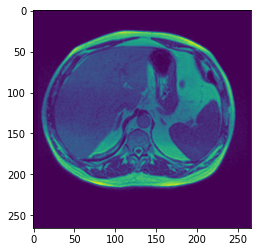

In [17]:
# cv2
# each value - [0, 255]

import cv2
print_img_info(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))

(266, 266)
[   0    0    0    0    0    0  437  418  380  475  513  323  323  399
  342 1539 3762 4598 4826 3078 1520 1026  779 1064 1691 2280 3325 3686
 3173 1995  836 2033 2451 2223 1900 2242 2508 2033 2470 2622 2242 2223
 2223 2394 2641 2470 2413 2337 2356 2375 2337 2299 2337 2242 1995 2014
 2280 2793 2698 2337 2261 2565 2945 2660 2318 2356 2489 2622 2622 2698
 2489 2622 2451 2584 2869 2508 2299 2527 2812 2603 2850 2831 2565 2546
 2451 2166 2451 2964 2660 2413 2755 2717 2736 2527 2413 2584 2527 2622
 2622 2603 2603 2489 2508 2660 2679 2280 2394 2318 2451 2679 2508 2622
 2394 2356 2261 1976 2033 2565 2641 2603 2565 2546 2660 2622 2717 2470
 2204 2660 2660 2736 3078 3667 4294 4256 4807 5263 5434 5453 4807 3876
 3800 3648 4218 5187 5567 6175 5681 5263 4959 3534 1881 1577 1843 2261
 3192 4541 5738 5149 3097 1482 1539 2850 3838 3610 3211 2679 2394 2356
 1881 1976 1976 1843 2147 1786 1615 2736 4712 6251 6897 7068 6745 6916
 7106 6973 7068 7068 6650 6688 6935 7011 7277 6783 7049 7486 7182 

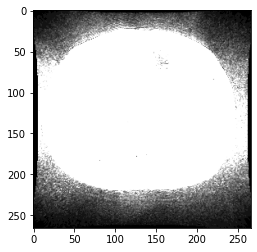

In [18]:
import PIL
print_img_info(PIL.Image.open(img_path, formats = ['PNG']))

(266, 266)
[   0.    0.    0.    0.    0.    0.  437.  418.  380.  475.  513.  323.
  323.  399.  342. 1539. 3762. 4598. 4826. 3078. 1520. 1026.  779. 1064.
 1691. 2280. 3325. 3686. 3173. 1995.  836. 2033. 2451. 2223. 1900. 2242.
 2508. 2033. 2470. 2622. 2242. 2223. 2223. 2394. 2641. 2470. 2413. 2337.
 2356. 2375. 2337. 2299. 2337. 2242. 1995. 2014. 2280. 2793. 2698. 2337.
 2261. 2565. 2945. 2660. 2318. 2356. 2489. 2622. 2622. 2698. 2489. 2622.
 2451. 2584. 2869. 2508. 2299. 2527. 2812. 2603. 2850. 2831. 2565. 2546.
 2451. 2166. 2451. 2964. 2660. 2413. 2755. 2717. 2736. 2527. 2413. 2584.
 2527. 2622. 2622. 2603. 2603. 2489. 2508. 2660. 2679. 2280. 2394. 2318.
 2451. 2679. 2508. 2622. 2394. 2356. 2261. 1976. 2033. 2565. 2641. 2603.
 2565. 2546. 2660. 2622. 2717. 2470. 2204. 2660. 2660. 2736. 3078. 3667.
 4294. 4256. 4807. 5263. 5434. 5453. 4807. 3876. 3800. 3648. 4218. 5187.
 5567. 6175. 5681. 5263. 4959. 3534. 1881. 1577. 1843. 2261. 3192. 4541.
 5738. 5149. 3097. 1482. 1539. 2850. 383

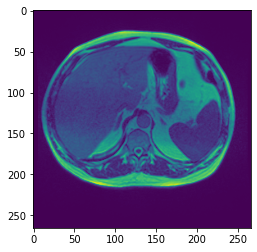

In [19]:
# keras
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img(img_path, color_mode = "grayscale")
img = tf.keras.preprocessing.image.img_to_array(img)
print_img_info(img[:, :, 0])

In [20]:
mask_seq = example_row.large_bowel

(266, 266, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


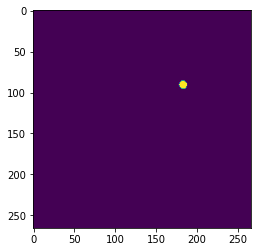

In [21]:
mask = rle_decode(mask_seq, img.shape)
print(mask.shape)
print(mask[90, :, 0])
plt.imshow(mask)

(128, 128, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


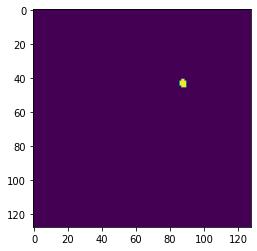

In [22]:
small_mask = tf.image.resize(mask, (128,128), method = 'nearest').numpy()
print(small_mask.shape)
print(small_mask[40, :, 0])
plt.imshow(small_mask)

(128, 128)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


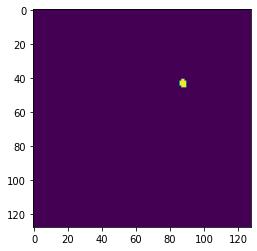

In [23]:
small_mask = cv2.resize(mask, (128,128))
print(small_mask.shape)
print(small_mask[40, :])
plt.imshow(small_mask)

### 4.2 Display several examples

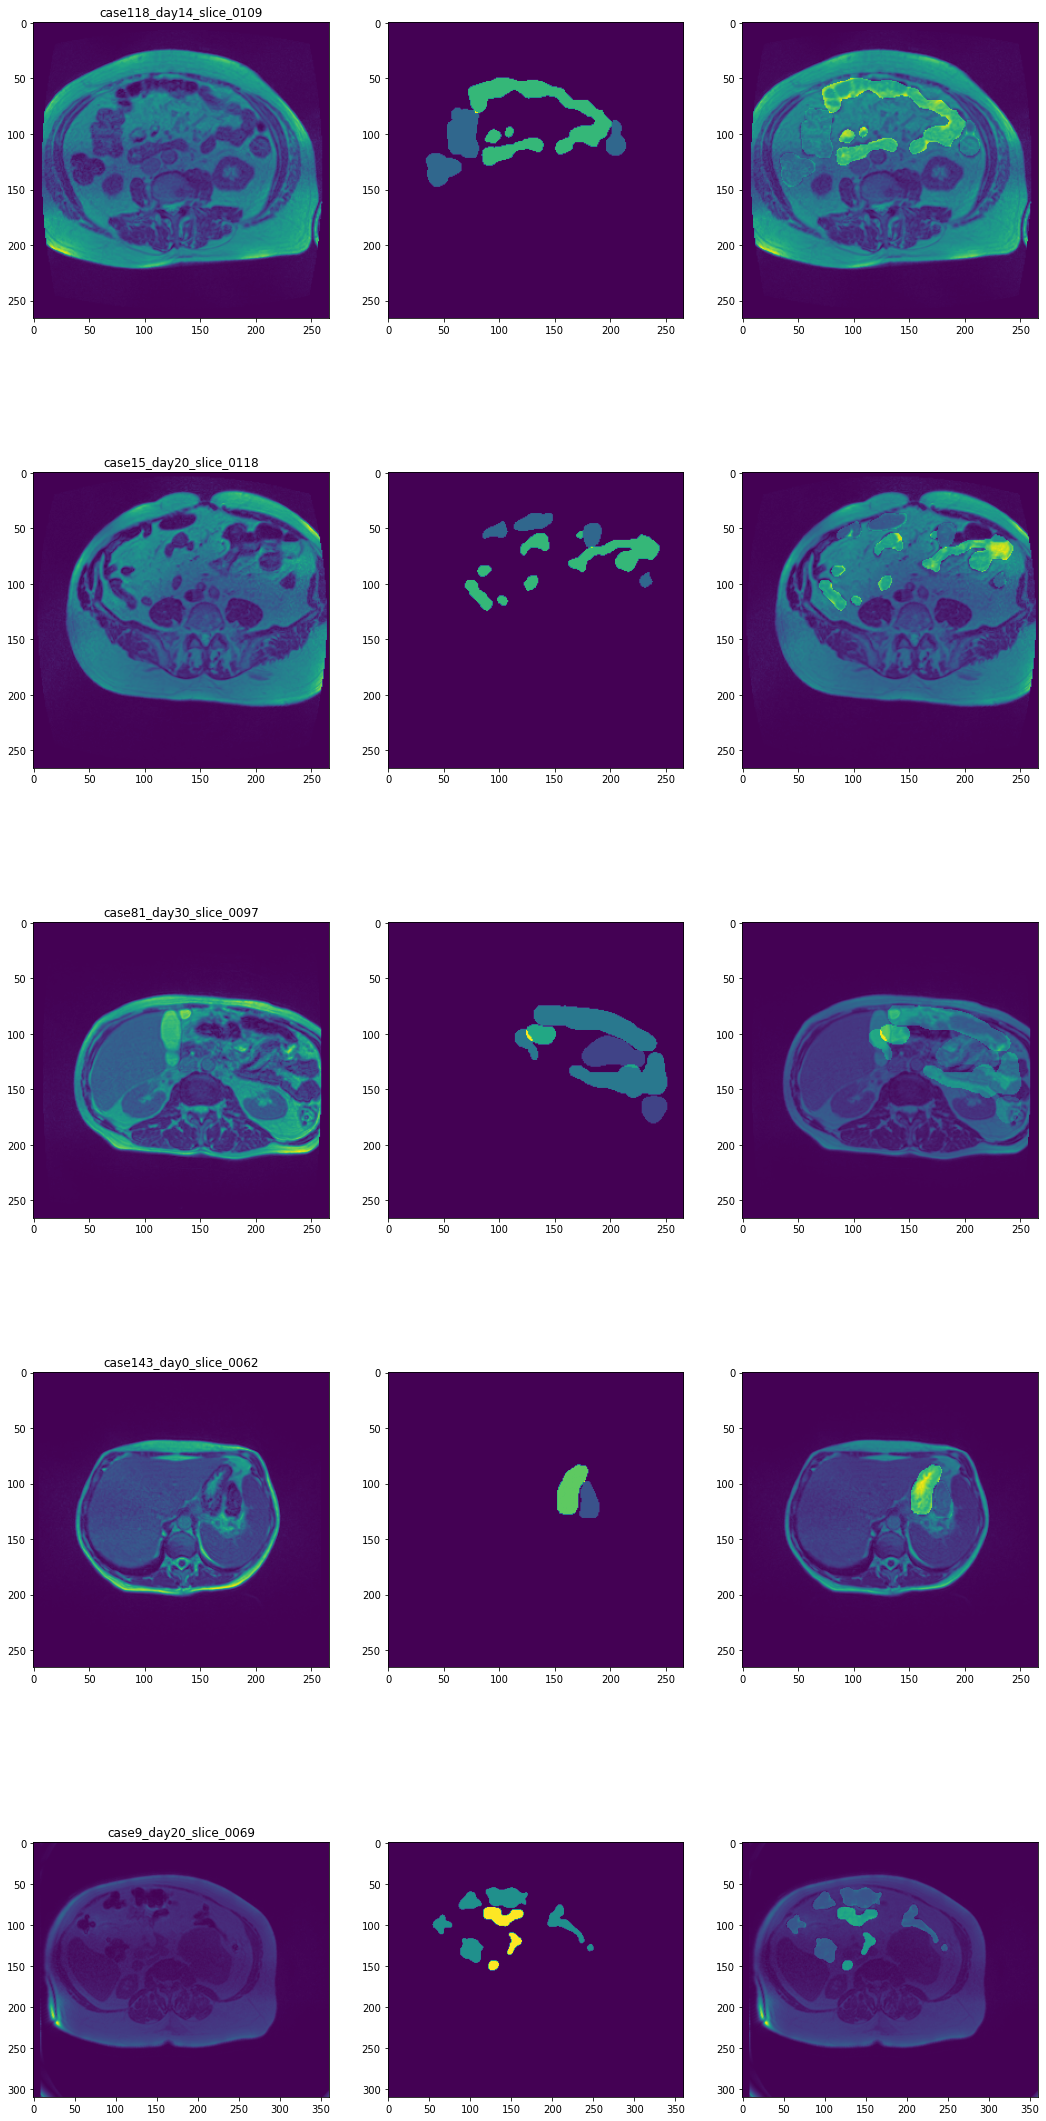

In [24]:
num = 5
segmentation_df_example = train_df_grouped[train_df_grouped.large_bowel != ''].sample(num)

fig, ax = plt.subplots(num, 3, figsize=(18, 8*num))
for i in range(num):
    record = segmentation_df_example.iloc[i, :]
    
    img = mpimg.imread(record.full_path, format = 'png')
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(record.id)
    
    mask = np.zeros(img.shape)
    for j, cl in enumerate(classes):
        mask += rle_decode(record[cl], img.shape)*(j + 1) / 4 * np.max(img)
    ax[i, 1].imshow(mask)
    
    ax[i, 2].imshow(img + mask)

## 5. Data Generator

In [25]:
from enum import Enum, auto

class GeneratorMode(Enum):
    TRAIN = auto()
    TEST = auto()

In [26]:
import tensorflow as tf
img_size = 160

class ImageDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                 df,
                 batch_size,
                 mode = GeneratorMode.TRAIN):

        self.df = df
        self.batch_size = batch_size
        self.image_size = img_size
        self.mode = mode
        
        self.len = len(df)
        
    def __getitem__(self, index):
        
        start, end = index * self.batch_size, (index + 1) * self.batch_size
        
        images = np.zeros((self.batch_size, self.image_size, self.image_size, 1))
        masks = np.zeros((self.batch_size, self.image_size, self.image_size, len(classes)))
        for i , pos in enumerate(range(start, end)):
            row = self.df.iloc[pos, :]
            
            #image
            image = tf.keras.preprocessing.image.load_img(row['full_path'], color_mode = "grayscale")
            image = tf.keras.preprocessing.image.img_to_array(image)
            image_shape = image.shape
            
            image = tf.image.resize(image, (self.image_size, self.image_size), method = 'nearest').numpy()
            image = image.reshape((self.image_size, self.image_size))
            images[i, :, :, 0] = image / 255.
            
            # masks (only train/val mode)
            if self.mode == GeneratorMode.TRAIN:
                for j, cl in enumerate(classes):
                    feat = row[cl]
                    mask = rle_decode(feat, image_shape)
                    mask = tf.image.resize(mask, (self.image_size, self.image_size), method = 'nearest').numpy()
                    mask = mask.reshape((self.image_size, self.image_size))
                    masks[i, :, :, j] = mask
              
        return (images, masks) if self.mode == GeneratorMode.TRAIN else images
                
    
    def __len__(self):
        return self.len // self.batch_size

In [27]:
# split train dataset into train and validation parts

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_df_grouped, test_size = 0.1, shuffle = True, random_state = 42)

In [28]:
train_data_gen = ImageDataGen(train_set, 64)
val_data_gen = ImageDataGen(val_set, 64)

## 6. Unet Model

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [30]:
# https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [31]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [32]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [33]:
def build_unet_model():
    inputs = layers.Input(shape=(img_size, img_size, 1))
    
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    bottleneck = double_conv_block(p4, 1024)
    
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    outputs = layers.Conv2D(len(classes), 1, padding="same", activation = "sigmoid")(u9)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [34]:
# metrics

# https://www.kaggle.com/code/samuelcortinhas/uwmgi-segmentation-unet-keras-inference

from keras import backend as K

# addind a 'smooth' value which equals to 1 just to avoid dividing by 0 in case y_true and y_pred consist of 0
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#intersection over union coefficient
def iou_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [35]:
# LOSS func

from tensorflow.keras.losses import BinaryCrossentropy

def loss_f(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred)
    
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [36]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                   loss = loss_f, metrics = [dice_coef, iou_coef])

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [37]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2, verbose = 1)

In [38]:
EPOCHS = 18
history = unet_model.fit(train_data_gen,
                         validation_data = val_data_gen, 
                         epochs = EPOCHS, callbacks = [early_stop, reduce_lr])

Epoch 1/18
541/541 [==============================] - 1507s 3s/step - loss: 0.8562 - dice_coef: 0.2241 - iou_coef: 0.2111 - val_loss: 0.7461 - val_dice_coef: 0.3103 - val_iou_coef: 0.2585
Epoch 2/18
541/541 [==============================] - 1241s 2s/step - loss: 0.5319 - dice_coef: 0.5033 - iou_coef: 0.4856 - val_loss: 0.4020 - val_dice_coef: 0.6221 - val_iou_coef: 0.5841
Epoch 3/18
541/541 [==============================] - 1242s 2s/step - loss: 0.3562 - dice_coef: 0.6671 - iou_coef: 0.6419 - val_loss: 0.3412 - val_dice_coef: 0.6799 - val_iou_coef: 0.5337
Epoch 4/18
541/541 [==============================] - 1244s 2s/step - loss: 0.2758 - dice_coef: 0.7420 - iou_coef: 0.7148 - val_loss: 0.2687 - val_dice_coef: 0.7479 - val_iou_coef: 0.5538
Epoch 5/18
541/541 [==============================] - 1241s 2s/step - loss: 0.2323 - dice_coef: 0.7827 - iou_coef: 0.7520 - val_loss: 0.2167 - val_dice_coef: 0.7975 - val_iou_coef: 0.7859
Epoch 6/18
541/541 [==============================] - 1239s 

## 7. Print acc/loss 

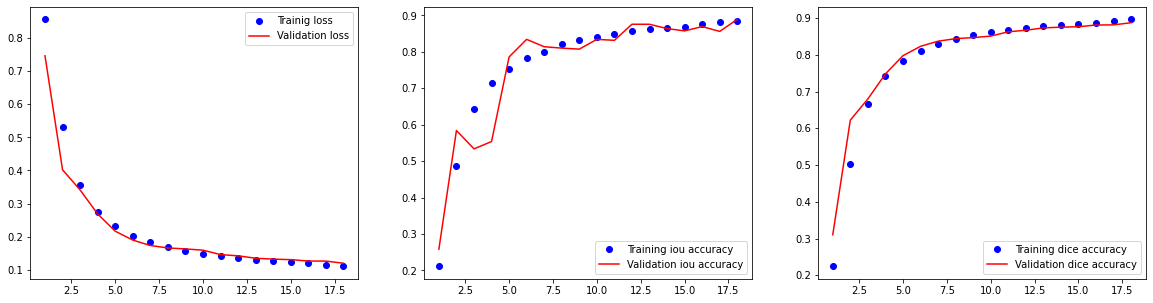

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

iou_coef = history.history['iou_coef']
val_iou_coef = history.history['val_iou_coef']

dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']


epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 5))

# loss
plt.subplot(1,3,1)
plt.plot(epochs, loss, 'bo', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

# iou
plt.subplot(1,3,2)
plt.plot(epochs, iou_coef, 'bo', label = 'Training iou accuracy')
plt.plot(epochs, val_iou_coef, 'r', label = 'Validation iou accuracy')
plt.legend()

# dice
plt.subplot(1,3,3)
plt.plot(epochs, dice_coef, 'bo', label = 'Training dice accuracy')
plt.plot(epochs, val_dice_coef, 'r', label = 'Validation dice accuracy')
plt.legend()

plt.show()

## 8. Predict result on validation set. Display result and compare it with initial masks

In [56]:
X, y = val_data_gen[2]
pred = unet_model.predict(X)

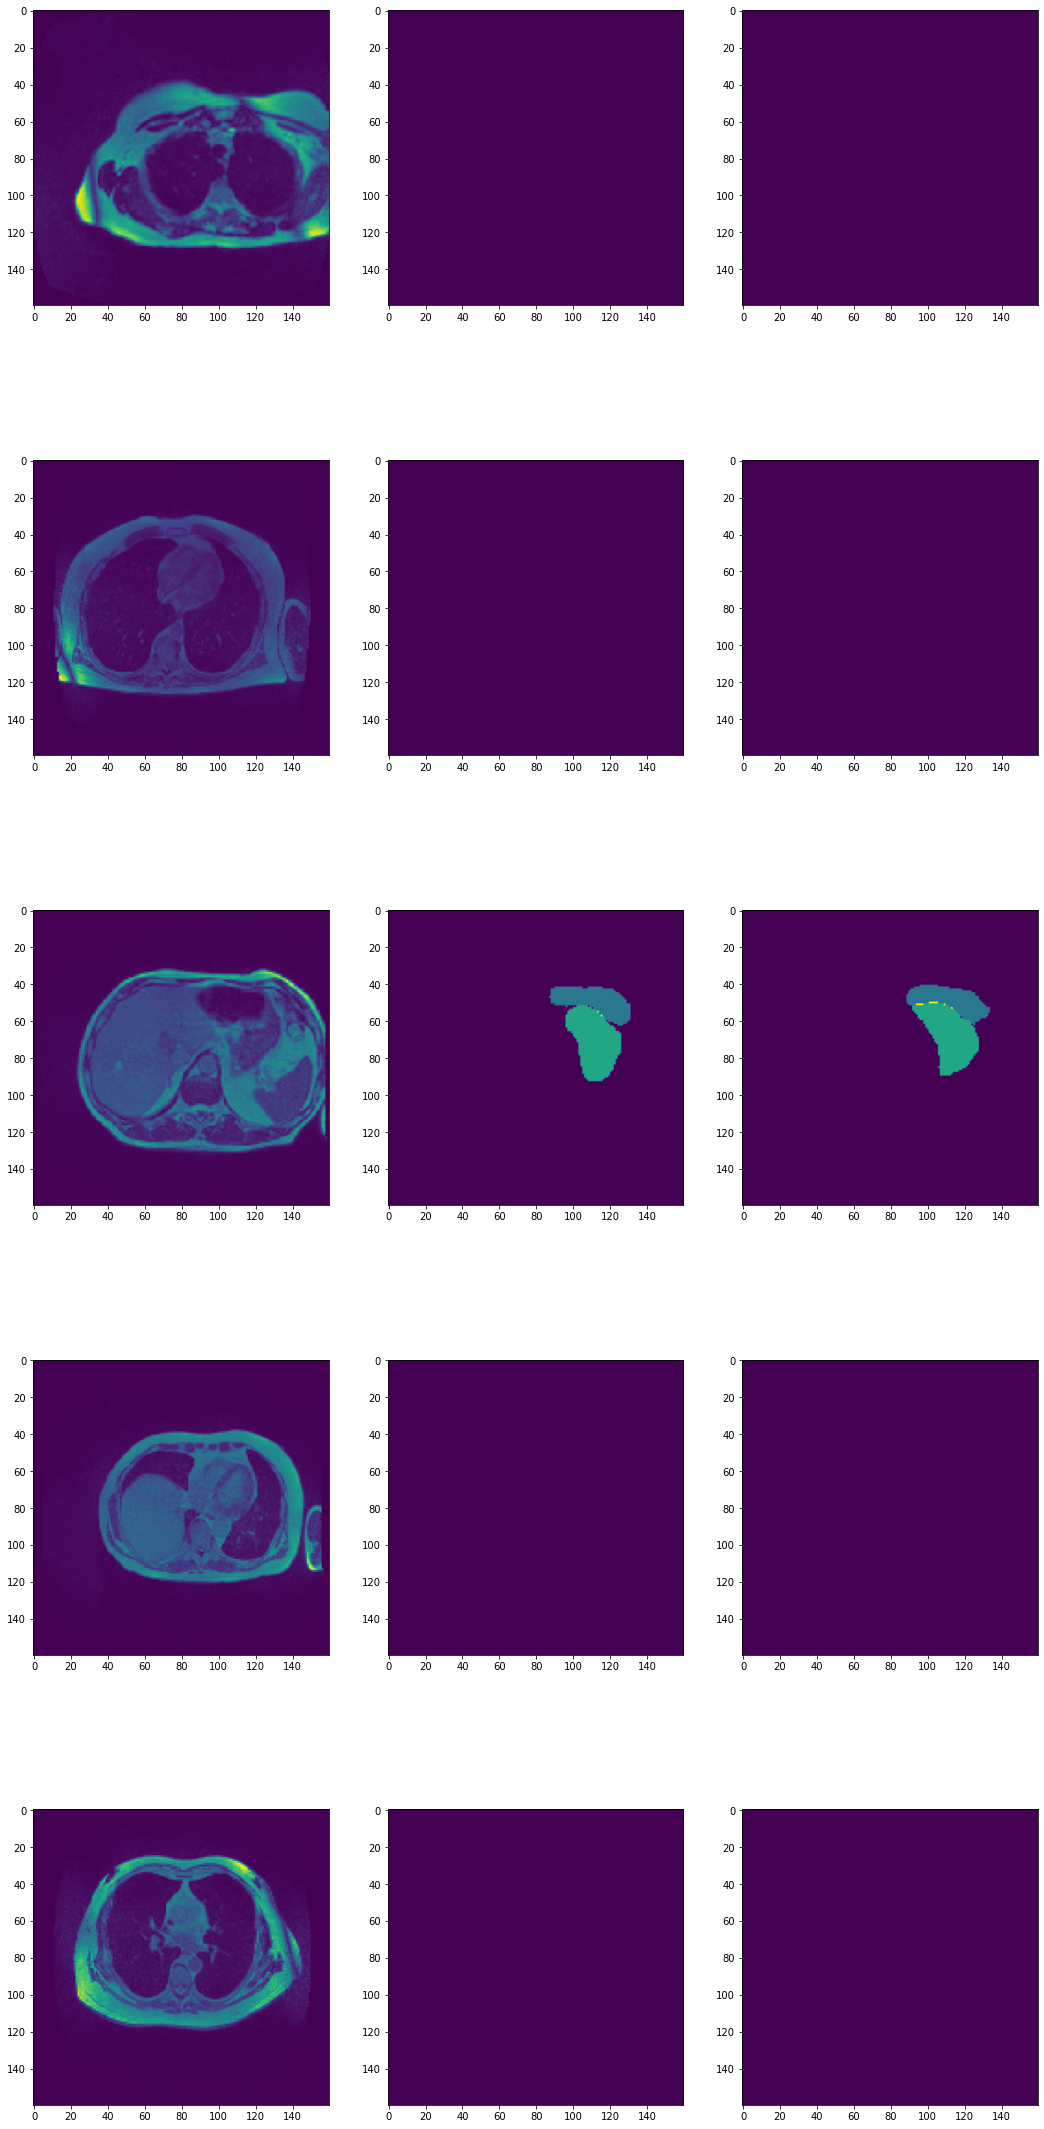

In [57]:
num = 5
fig, ax = plt.subplots(num, 3, figsize=(18, 8 * num))

for i in range(num):
    img = X[i, :, :, 0]
    masks = y[i]
    pred_masks = pred[i]
    ax[i, 0].imshow(img)
    
    mask = np.zeros(masks.shape[:-1])
    for j in range(masks.shape[-1]):
        m = masks[:, :, j]
        mask += m*(j+1)/4*np.max(img)
    ax[i, 1].imshow(mask)
    
    pred_mask = np.zeros(masks.shape[:-1])
    for j, cl in enumerate(classes):
        m = (pred_masks[:, :, j] > 0.5).astype(np.float32)
        pred_mask += m*(j+1)/4*np.max(img)
    ax[i, 2].imshow(pred_mask)

## 9. Test dataset

In [58]:
# Test set
test_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')

if len(test_df) == 0:
    DEBUG = True
    test_df = train_df.iloc[:10*16*3,:].copy()
    test_df.loc[:, "segmentation"] = ''
    test_df = test_df.rename(columns = {"segmentation":"predicted"})
else:
    DEBUG = False

submission = test_df.copy()
test_df.head()

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


### 9.1 Download all .png files to DataFrame

In [59]:
path = test_folder if not DEBUG else train_folder
path

'/kaggle/input/uw-madison-gi-tract-image-segmentation/train'

In [60]:
# create dataset structured like 'train_df_grouped' 
test_df = process_df(test_df['id'].drop_duplicates().to_frame(), path)
test_df

,id,case,day,slice_,full_path
0,case123_day20_slice_0001,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...
1,case123_day20_slice_0002,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...
2,case123_day20_slice_0003,123,20,0003,/kaggle/input/uw-madison-gi-tract-image-segmen...
3,case123_day20_slice_0004,123,20,0004,/kaggle/input/uw-madison-gi-tract-image-segmen...
4,case123_day20_slice_0005,123,20,0005,/kaggle/input/uw-madison-gi-tract-image-segmen...
...,...,...,...,...,...
155,case123_day22_slice_0012,123,22,0012,/kaggle/input/uw-madison-gi-tract-image-segmen...
156,case123_day22_slice_0013,123,22,0013,/kaggle/input/uw-madison-gi-tract-image-segmen...
157,case123_day22_slice_0014,123,22,0014,/kaggle/input/uw-madison-gi-tract-image-segmen...
158,case123_day22_slice_0015,123,22,0015,/kaggle/input/uw-madison-gi-tract-image-segmen...


### 9.2 DataGenerator

In [45]:
test_datagen = ImageDataGen(test_df, batch_size = 1, mode = GeneratorMode.TEST)

### 9.3 Predict

In [46]:
for i in range(len(test_df)):
    pred = unet_model.predict(test_datagen[i])[0]
    pred = (pred > 0.5).astype(np.float32)
    
    # remember that shape is (160x160x3)!
    # so we need to resize predicted mask back to image size
    img = mpimg.imread(test_df.iloc[i, :].full_path, format = 'png')
    pred = tf.image.resize(pred, img.shape, method = 'nearest').numpy()

    for j in range(pred.shape[-1]):
        id = test_df.iloc[i, :].id
        cls = classes[j]
        mask = pred[:, :, j]
        submission.loc[(submission['id'] == id) & (submission['class'] == cls), 'predicted'] = rle_encode(mask)
        
submission.head()

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


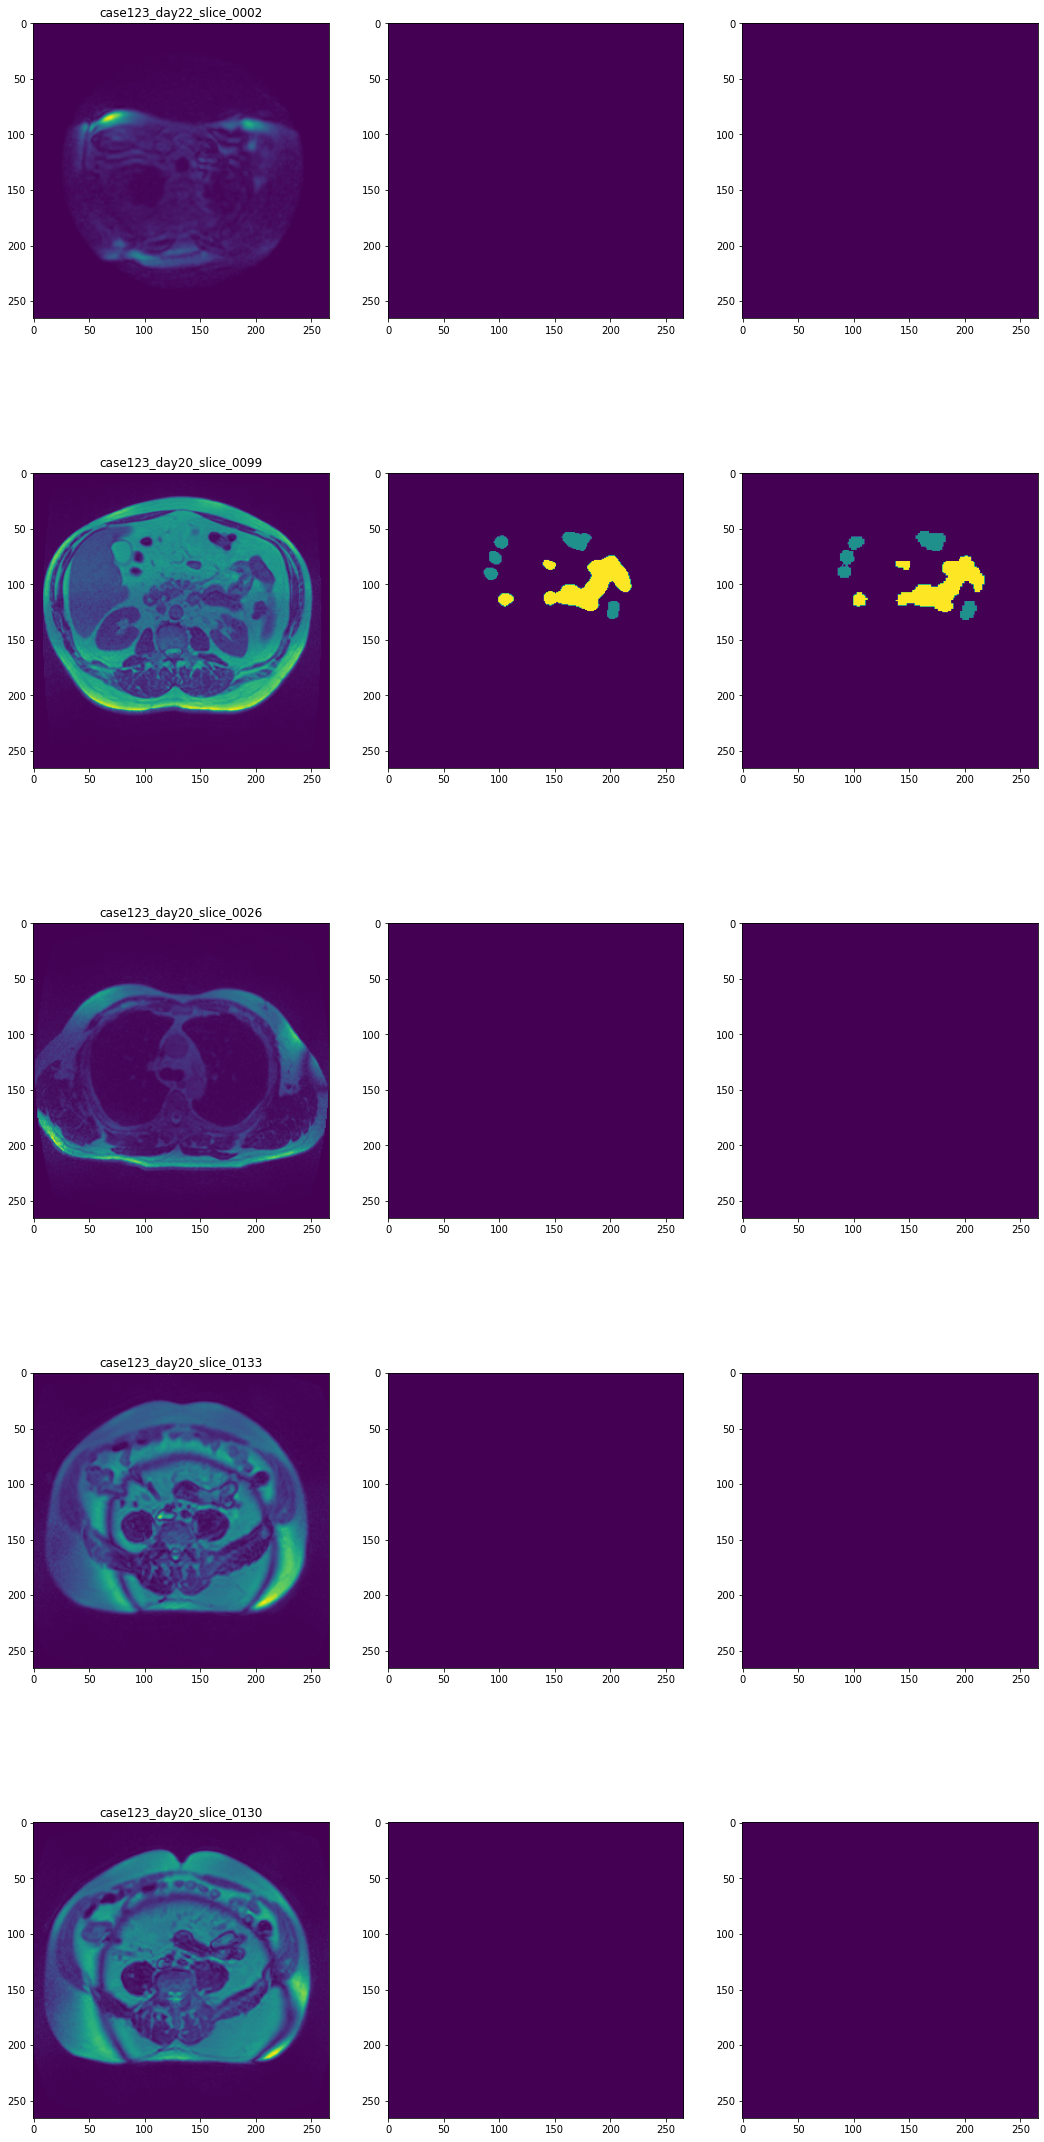

In [47]:
# display predicted and resized masks

import random

if DEBUG:
    num = 5
    ids = random.choices(test_df.id.unique().tolist(), k = num)
    fig, ax = plt.subplots(num, 3, figsize=(18, 8 * num))

    for i in range(num):
        original = train_df_grouped[train_df_grouped.id == ids[i]]
        predicted = submission[submission.id == ids[i]]

        img = mpimg.imread(original.full_path.values[0], format = 'png')
        ax[i, 0].imshow(img)
        ax[i, 0].set_title(ids[i])
        
        mask = np.zeros(img.shape)
        for j, cl in enumerate(classes):
            mask += rle_decode(original[cl].values[0], img.shape)*(j + 1) / 4 * np.max(img)
        ax[i, 1].imshow(mask)

        
        pred_mask = np.zeros(img.shape)
        for j, cl in enumerate(classes):
            pred_mask += rle_decode(predicted[predicted['class'] == cl]['predicted'].values[0], img.shape)*(j + 1) / 4 * np.max(img)
        ax[i, 2].imshow(pred_mask)

In [61]:
model_file_path = 'unet_model.h5'

# Save the model to the specified file path
unet_model.save(model_file_path)

print(f"Model saved to {model_file_path}")


Model saved to unet_model.h5


### 9.4 Submit

In [48]:
# from overview:
# Submission file must be named submission.csv
submission.to_csv('submission.csv',index = False)